In [2]:
import copy
import numpy as np
import pandas as pd
from jiwer import wer
import seaborn as sns
from scipy import stats
from pprint import pprint
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from transcript_processing import preprocess_talkbank_text

/Users/gmaheshw/codes/anaconda3/envs/diabolocom/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
def calculate_wer(reference, hypothesis, apply_preprocessing_on_reference=True, apply_preprocessing_on_hypothesis=True):
    if apply_preprocessing_on_reference:
        reference = preprocess_talkbank_text(reference, remove_tags=True, remove_beg_unfinished_word=True, lower=True, remove_accents=True)
    if apply_preprocessing_on_hypothesis:
        hypothesis = preprocess_talkbank_text(hypothesis, remove_tags=True, remove_beg_unfinished_word=True, lower=True, remove_accents=True)
        
    try:
        return wer(reference, hypothesis)
    except TypeError:
        print(reference, hypothesis)
        

def aggregate_results(series):
    return series.mean()

In [4]:
all_datasets = {
 "talkbank_switch": "data/talkbank_df_switch.csv",
 "talkbank_segments": "data/talkbank_df_segments.csv",
 "librespeech": "data/librispeech_df.csv",
 "fleurs": "data/fleurs_df.csv",
 "commonvoice": "data/commonvoice_df.csv"
}

In [5]:
all_dataframe = {}
model = ["canary","whisper", "wav2vec256"]
for dataset, location in tqdm(all_datasets.items()):
    df = pd.read_csv(location)
    for m in model:
        if m in df.columns:
            df[f"wer_{m}"] = df.apply(lambda row: calculate_wer(row['transcription'], row[m], True, True), axis=1)
    all_dataframe[dataset] = df

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

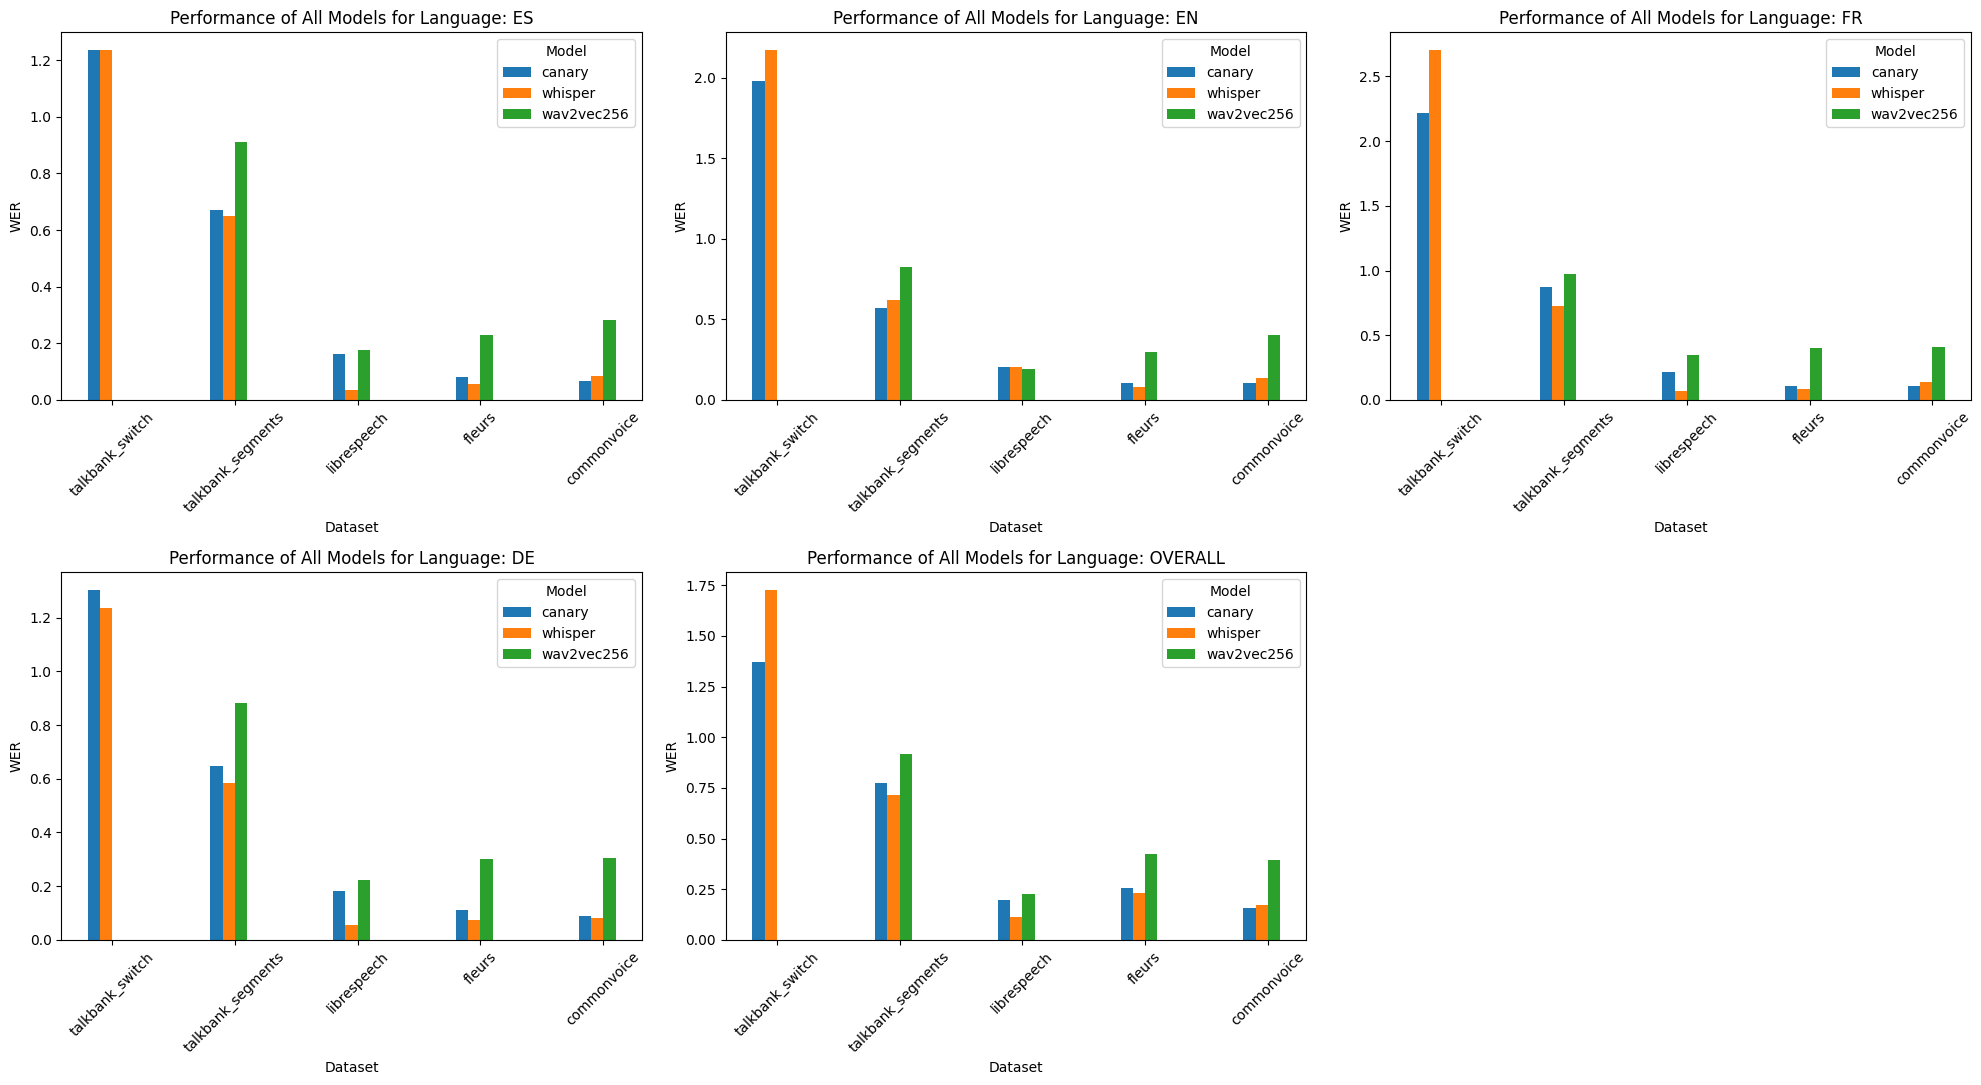

In [6]:
# plot the curves
'''

k1 and k2 represent the minimum and maximum time duration segment. For benchmarking on completete dataset put k1 as 0 and k2 as 200000000 (just a very large number)

'''
model = ["canary","whisper", "wav2vec256"]
all_results = []
for dataset, location in tqdm(all_datasets.items()):
    df = all_dataframe[dataset]
    k1 = 0
    k2 = 2000000000
    if "audio_len_sec" in df.columns:
        cln_name = "audio_len_sec"
    else:
        cln_name = "lenght"
    df = df[(df[cln_name] >= k1) & (df[cln_name] <= k2)]
    # df = df[(df[cln_name] <= k1)]
    for m in model:
        for ln in df["language"].unique():
            if dataset == "talkbank_switch" and m == "wav2vec256":
                all_results.append([dataset, m, ln, 0.0])
            else:

                language_df = df[df["language"] == ln]
                result = aggregate_results(language_df[f"wer_{m}"])
                all_results.append([dataset, m, ln, result])
        
        if dataset == "talkbank_switch" and m == "wav2vec256":
                result = 0.0
        else:
            result = aggregate_results(df[f"wer_{m}"])
        all_results.append([dataset, m, "overall", result])
        
        
df = pd.DataFrame(all_results, columns=['Dataset', 'Model', 'Language', 'Score'])

# Plotting the performance of all models for each language grouped by dataset
languages = df['Language'].unique()
languages = ["es", "en", "fr", "de", "overall"]

plt.figure(figsize=(20, 15))


for index, language in enumerate(languages):
    
    plt.subplot(3,3,index+1)
    
    subset = df[df['Language'] == language]
    
    # Get unique datasets and models
    datasets = subset['Dataset'].unique()
    index = np.arange(len(datasets))
    # _ = datasets.remove("talkbank_switch")
    # datasets.append("talkbank_switch")
    models = subset['Model'].unique()
    
    # dataset_to_index_mapper = {data_set:i for data_set, i in enumerate(datasets)}
    
    
    # Set up bar width and positions
    bar_width = 0.1
    
    
    for i, model in enumerate(models):
        model_data = subset[subset['Model'] == model]
        # print(model_data)
        # print(index + i * bar_width, len(model_data), len(model_data['Score']))
        # index = np.arange(len(model_data))
        plt.bar(index + i * bar_width, model_data['Score'], bar_width, label=model)
        
    
    
    plt.xlabel('Dataset')
    plt.ylabel('WER')
    plt.title(f'Performance of All Models for Language: {language.upper()}')
    plt.xticks(index + bar_width * (len(models) / 2), datasets, rotation=45)
    plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [7]:
df = all_dataframe["talkbank_segments"]
def correlation_df(df):
    
    NEW_TAGS = {
	"non-verbal": "✦non verbal✦",
	"laugh": "✦laugh✦",
	"unintelligible": "✦unintelligible✦",
	"special-character": "✦special character✦",
	"pause": "✦pause✦",
	"bracket": "✦bracket✦",
	"special-utterance-terminator": "✦special utterance terminator✦",
	"event": "✦event✦",
	"interposed-word": "✦interposed word✦",
}
    
    
    NEW_TAGS = {
	"non-verbal": "✦non verbal✦",
	"laugh": "✦laugh✦",
	"unintelligible": "✦unintelligible✦",

	"pause": "✦pause✦",
	"bracket": "✦bracket✦",

	"event": "✦event✦",

}
    
    new_tags = [i for i in NEW_TAGS.values()]
    
    
    def temp(text, newtags):
        text = preprocess_talkbank_text(text, remove_tags=False, remove_beg_unfinished_word=False, lower=True, remove_accents=False)

        denom = len(text.split(" "))*1.0

        return sum([text.count(i) for i in newtags])/denom
    
    
    
    for newtags in new_tags:
        print(newtags)
        df["special_tag_count"] = df.apply(lambda row: temp(row['transcription'], [newtags]), axis=1)
        # return df
        for m in ["whisper", "canary", "wav2vec256"]:
            m_string = f"wer_{m}"
            result = df["special_tag_count"].corr(df[m_string])
            print(f"{m}: {result}")
            
        print("****")
    
    print("overall")
    df["special_tag_count"] = df.apply(lambda row: temp(row['transcription'], new_tags), axis=1)

    for m in ["whisper", "canary", "wav2vec256"]:
        m_string = f"wer_{m}"
        result = df["special_tag_count"].corr(df[m_string])
        print(f"{m}: {result}")

correlation_df(df)

✦non verbal✦
whisper: 0.11108002497109898
canary: 0.07362727118631138
wav2vec256: 0.08784874755079379
****
✦laugh✦
whisper: 0.1095761662604748
canary: 0.059738971626025594
wav2vec256: 0.0849534008792984
****
✦unintelligible✦
whisper: 0.1440059943020521
canary: 0.08060493716406895
wav2vec256: 0.12437498037342745
****
✦special character✦
whisper: 0.15760199813824546
canary: 0.08479220545782688
wav2vec256: 0.11444798858968727
****
✦pause✦
whisper: 0.05534862890514162
canary: 0.026719793256357746
wav2vec256: 0.019810792614778826
****
✦bracket✦
whisper: 0.03934082736447964
canary: 0.03309532649860805
wav2vec256: 0.03390705295085125
****
✦special utterance terminator✦
whisper: -0.01277817699192345
canary: -0.013023767863000761
wav2vec256: -0.015063914574030779
****
✦event✦
whisper: 0.16703097329865235
canary: 0.12257461582746108
wav2vec256: 0.16854022383366685
****
✦interposed word✦
whisper: nan
canary: nan
wav2vec256: nan
****
overall
whisper: 0.2898959528022451
canary: 0.18183795586635043


['Canary', 'Whisper', 'Wav2Vec2']
              Dataset   Model Language     Score
0     TalkBank Switch  Canary       es  1.236482
22  TalkBank Segments  Canary       es  0.671925
43        LibreSpeech  Canary       es  0.163266
60             Fleurs  Canary       es  0.082143
79        CommonVoice  Canary       es  0.065357
              Dataset    Model Language     Score
7     TalkBank Switch  Whisper       es  1.236750
29  TalkBank Segments  Whisper       es  0.649397
48        LibreSpeech  Whisper       es  0.035211
66             Fleurs  Whisper       es  0.055419
85        CommonVoice  Whisper       es  0.083594
              Dataset     Model Language     Score
14    TalkBank Switch  Wav2Vec2       es  0.000000
36  TalkBank Segments  Wav2Vec2       es  0.909970
53        LibreSpeech  Wav2Vec2       es  0.177614
72             Fleurs  Wav2Vec2       es  0.230208
91        CommonVoice  Wav2Vec2       es  0.281620
              Dataset   Model Language     Score
1     TalkBank Sw

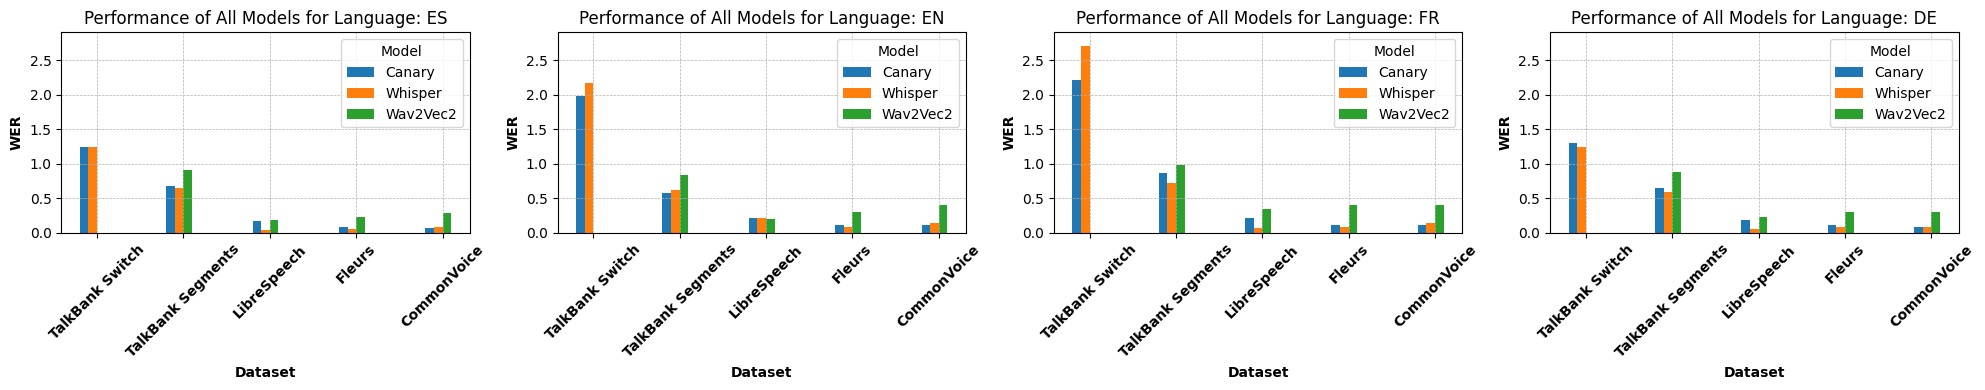

In [8]:
df = pd.DataFrame(all_results, columns=['Dataset', 'Model', 'Language', 'Score'])



model = ["Canary","Whisper", "Wav2Vec2"]


string_replace_lookup = {
    
    "talkbank_switch": "TalkBank Switch",
    "talkbank_segments": "TalkBank Segments",
    "librespeech": "LibreSpeech",
    "commonvoice": "CommonVoice",
    "fleurs":"Fleurs",
    "canary": "Canary",
    "wav2vec256": "Wav2Vec2",
    "whisper": "Whisper"
}


for old, new in string_replace_lookup.items():
        df['Dataset'] = df['Dataset'].str.replace(old, new, regex=False)
        df['Model'] = df['Model'].str.replace(old, new, regex=False)
        
        

# Plotting the performance of all models for each language grouped by dataset
languages = df['Language'].unique()
languages = ["es", "en", "fr", "de", "overall"]


common_ylim = (0, df['Score'].max()+0.2)
plt.figure(figsize=(20, 4))




print(model)

for index, language in enumerate(languages):
    
    if language == "overall":
        continue
    plt.subplot(1,4,index+1)
    
    subset = df[df['Language'] == language]
    
    
    
    # Get unique datasets and models
    datasets = subset['Dataset'].unique()
    index = np.arange(len(datasets))
    # _ = datasets.remove("talkbank_switch")
    # datasets.append("talkbank_switch")
    models = subset['Model'].unique()
    
    # dataset_to_index_mapper = {data_set:i for data_set, i in enumerate(datasets)}
    
    
    # Set up bar width and positions
    bar_width = 0.1
    
    
    for i, model in enumerate(models):
        model_data = subset[subset['Model'] == model]
        print(model_data)
        # print(index + i * bar_width, len(model_data), len(model_data['Score']))
        # index = np.arange(len(model_data))
        plt.bar(index + i * bar_width, model_data['Score'], bar_width, label=model)
        
    
    
    plt.xlabel('Dataset', fontweight="bold")
    plt.ylabel('WER', fontweight="bold")
    plt.title(f'Performance of All Models for Language: {language.upper()}')
    plt.xticks(index + bar_width * (len(models) / 2), datasets, rotation=45, fontweight="bold")
    plt.legend(title='Model')
    plt.ylim(common_ylim)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("language_based_performance.pdf")
plt.show()

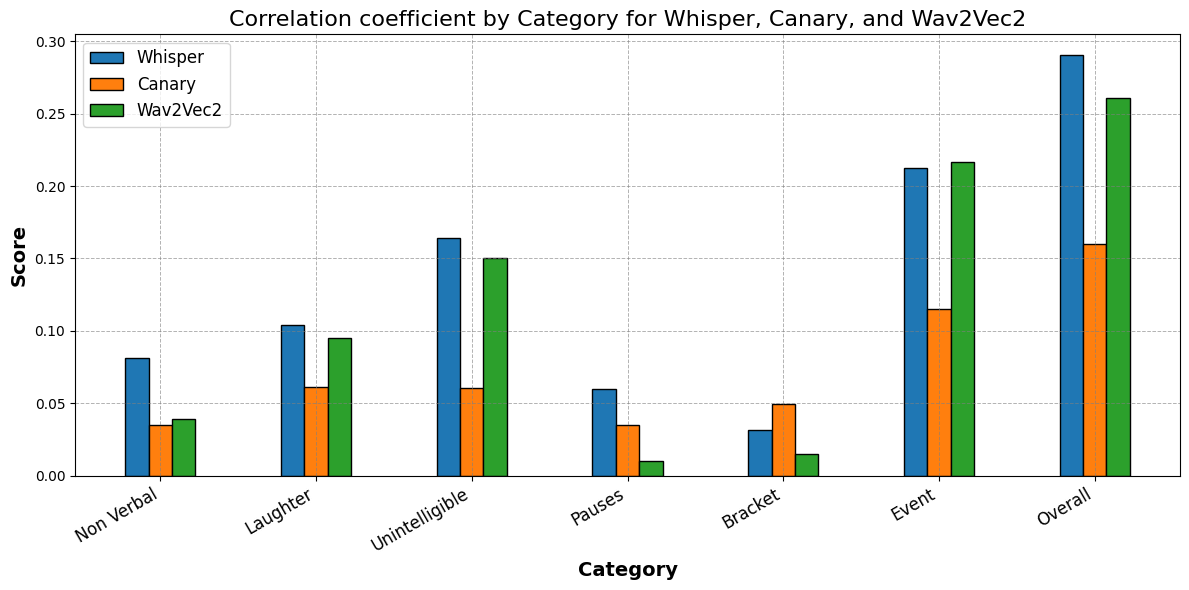

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data
categories = ['non verbal', 'laugh', 'unintelligible', 'special character', 'pause', 'bracket', 'special utterance terminator', 'event', 'overall']
whisper_scores = [0.08147028973395591, 0.10385430643026726, 0.16446031030893765, 0.1831626499093063, 0.060106983877880694, 0.03174820837491338, -0.027517846441555156, 0.21264420377094087, 0.3246636828864943]
canary_scores = [0.03495260177692338, 0.06126677907241109, 0.06081633040017965, 0.12656232426046743, 0.034949554561800295, 0.04940595832230018, -0.03068935433634499, 0.11490995264751087, 0.18846749295031084]
wav2vec256_scores = [0.03944013037303862, 0.09527284120364453, 0.15032501818829452, 0.10677824663220141, 0.0100260587482182, 0.015091388831254927, -0.03593126407373087, 0.21634111609073228, 0.26487304256501576]

categories = ['Non Verbal', 'Laughter', 'Unintelligible', 'Pauses', 'Bracket',  'Event', 'Overall']
whisper_scores = [0.08147028973395591, 0.10385430643026726, 0.16446031030893765,  0.060106983877880694, 0.03174820837491338,  0.21264420377094087, 0.290328530318895]
canary_scores = [0.03495260177692338, 0.06126677907241109, 0.06081633040017965, 0.034949554561800295, 0.04940595832230018,  0.11490995264751087, 0.15984690352756115]
wav2vec256_scores = [0.03944013037303862, 0.09527284120364453, 0.15032501818829452,  0.0100260587482182, 0.015091388831254927, 0.21634111609073228, 0.2608486150310203]



# DataFrame
df = pd.DataFrame({
    'Category': categories,
    'Whisper': whisper_scores,
    'Canary': canary_scores,
    'Wav2Vec256': wav2vec256_scores
})

# Set position of bars on X axis
bar_width = 0.15
r1 = np.arange(len(df))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(r1, df['Whisper'], color='#1f77b4', width=bar_width, edgecolor='black', label='Whisper')
plt.bar(r2, df['Canary'], color='#ff7f0e', width=bar_width, edgecolor='black', label='Canary')
plt.bar(r3, df['Wav2Vec256'], color='#2ca02c', width=bar_width, edgecolor='black', label='Wav2Vec2')

# Adding labels and title
plt.xlabel('Category', fontweight='bold', fontsize=14)
plt.ylabel('Score', fontweight='bold', fontsize=14)
plt.xticks([r + bar_width for r in range(len(df))], df['Category'], rotation=30, ha='right', fontsize=12)
plt.title('Correlation coefficient by Category for Whisper, Canary, and Wav2Vec2', fontsize=16)

# Adding grid with improved aesthetics
plt.grid(True, which='major', linestyle='--', linewidth=0.7, color='gray', alpha=0.6)

# Adding legend with better placement
plt.legend(loc='upper left', fontsize=12)

# Tight layout for better spacing
plt.tight_layout()

# Show plot
plt.show()